---

## 📘 **Automatización de Alertas de Heladas para Viñedos con Python**

### Proyecto certificado por Kubicle: *Python – Connecting to Live Data*

---

### 🧊 1. Contexto del Problema

> **Caso real:** La empresa vitivinícola *Vino Veritas* perdió **\$65,000** por un error humano en la predicción de heladas.
>
> **Objetivo:** Automatizar la consulta de pronósticos y generar alertas de riesgo de heladas para **17 viñedos**, integrando múltiples fuentes de datos y APIs en Python.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install streamlit
!pip install python-dotenv
!pip install streamlit-folium

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 111.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 7.9 MB/s eta 0:00:00




## ⚙️ 2. Pasos Técnicos del Proyecto

---

### 🛰️ Paso 1: Conexión a la API y Configuración

In [17]:
import requests
import os
from dotenv import load_dotenv

# Cargar credenciales desde archivo .env
load_dotenv("/content/drive/MyDrive/Colab Notebooks/Kubicle/Automatizacion_Heladas_viñedos/.env")
API_KEY = os.getenv("API_KEY")
BASE_URL = "http://api.weatherapi.com/v1/forecast.json"

---

### 🧾 Paso 2: Carga y Unión de Datasets

In [18]:
import pandas as pd

# Cargar viñedos (local) y coordenadas (remoto)
vineyards = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Kubicle/Automatizacion_Heladas_viñedos/vineyards.csv")
city_lat_long = pd.read_csv("https://ac-101708228-virtuoso-prod.s3.amazonaws.com/uploads/download/119/city_lat_long.csv")

# Cargar tabla de códigos Alpha-2 desde página oficial (HTML)
alpha2_codes = pd.read_html("https://www.iban.com/country-codes")[0]


---

#### ✨ Normalización de nombres de países

In [19]:
# Mapeo manual de países
country_name_map = {
    'United States of America (the)': 'United States',
    'Czech Republic': 'Czechia',
    'South Korea': 'Korea, Republic of'
}

vineyards['Country'] = vineyards['Country'].replace(country_name_map)
alpha2_codes['Country'] = alpha2_codes['Country'].replace(country_name_map)

---

### 🔗 Merge 1: Códigos Alpha-2

In [20]:
vineyards_alpha2 = pd.merge(
    vineyards,
    alpha2_codes[["Country", "Alpha-2 code"]],
    on="Country",
    how="left"
)

---

### 🌍 Merge 2: Coordenadas Geográficas


In [21]:
final_data = pd.merge(
    vineyards_alpha2,
    city_lat_long,
    on=["City", "Alpha-2 code"],
    how="left"
)

---

### 🧪 Verificación del Merge

In [22]:
# Ver cuántos viñedos tienen coordenadas
print(f"Coordenadas disponibles: {final_data['lat,long'].notnull().sum()} de {len(final_data)}")

Coordenadas disponibles: 18 de 18



---

### 🧼 Limpieza de Coordenadas (lat, long)

In [23]:
import numpy as np

# Separar latitud y longitud
final_data["lat"] = np.nan
final_data["long"] = np.nan

def split_coords(coord_str):
    try:
        if pd.isna(coord_str): return (np.nan, np.nan)
        parts = coord_str.split(',')
        return float(parts[0].strip()), float(parts[1].strip())
    except:
        return (np.nan, np.nan)

coords = final_data["lat,long"].apply(split_coords)
final_data["lat"] = coords.str[0]
final_data["long"] = coords.str[1]

# Verificación
print(final_data[["Vineyard Name", "lat", "long"]].head())

              Vineyard Name        lat        long
0          Braur Du Mathtel  49.074299   -0.523900
1                Las Spacer  37.271461   -4.229220
2          Sagplaines Haven -30.483330  138.416672
3  Grand Ningoaks Du Marmid  49.431068   -1.691680
4               Sland Creek  31.385719  -85.929390


---

### ☁️ Paso 3: Consulta a la API (Pronóstico)

In [25]:
# Inicializar columnas para temperaturas mínimas
final_data["Today+1 Min Temp"] = None
final_data["Today+2 Min Temp"] = None
final_data["Today+3 Min Temp"] = None

# Loop sobre viñedos
for idx, row in final_data.iterrows():
    if pd.isnull(row['lat']) or pd.isnull(row['long']):
        continue

    coords = f"{row['lat']},{row['long']}"
    response = requests.get(f"{BASE_URL}?key={API_KEY}&q={coords}&days=3")

    if response.status_code == 200:
        forecast = response.json()["forecast"]["forecastday"]
        final_data.at[idx, "Today+1 Min Temp"] = forecast[0]["day"]["mintemp_c"]
        final_data.at[idx, "Today+2 Min Temp"] = forecast[1]["day"]["mintemp_c"]
        final_data.at[idx, "Today+3 Min Temp"] = forecast[2]["day"]["mintemp_c"]

---

### 💾 Paso 4: Exportación de Resultados

In [26]:
# Exportar datos enriquecidos
final_data.to_csv("vineyards_forecast.csv", index=False)
print("✅ Archivo 'vineyards_forecast.csv' guardado correctamente.")

✅ Archivo 'vineyards_forecast.csv' guardado correctamente.


---

## ✅ 3. Validación del Proyecto (Checklist Kubicle)

| Requisito                  | Verificado ✅                                  |
| -------------------------- | --------------------------------------------- |
| Conexión a API             | ✔️ (WeatherAPI con lat/long)                  |
| Fusión de datasets         | ✔️ (`vineyards`, `city_lat_long`, tabla HTML) |
| Coordinación país + ciudad | ✔️ (Merge con `Alpha-2 code`)                 |
| Predicción 3 días          | ✔️ (`Today+1`, `Today+2`, `Today+3 Min Temp`) |

---

## 📍 4. Visualización Geográfica con Folium

In [27]:
import folium

map_center = [final_data["lat"].mean(), final_data["long"].mean()]
frost_map = folium.Map(location=map_center, zoom_start=2)

for _, row in final_data.iterrows():
    if pd.notnull(row["lat"]) and pd.notnull(row["Today+1 Min Temp"]):
        popup_text = f"""
        <b>Viñedo:</b> {row['Vineyard Name']}<br>
        <b>País:</b> {row['Country']}<br>
        <b>Min Temp Día 1:</b> {row['Today+1 Min Temp']}°C
        """
        folium.Marker(
            location=[row["lat"], row["long"]],
            popup=popup_text,
            icon=folium.Icon(color="red" if float(row["Today+1 Min Temp"]) < 5 else "green")
        ).add_to(frost_map)

frost_map

## 📊 5. Gráfico de Temperaturas Mínimas

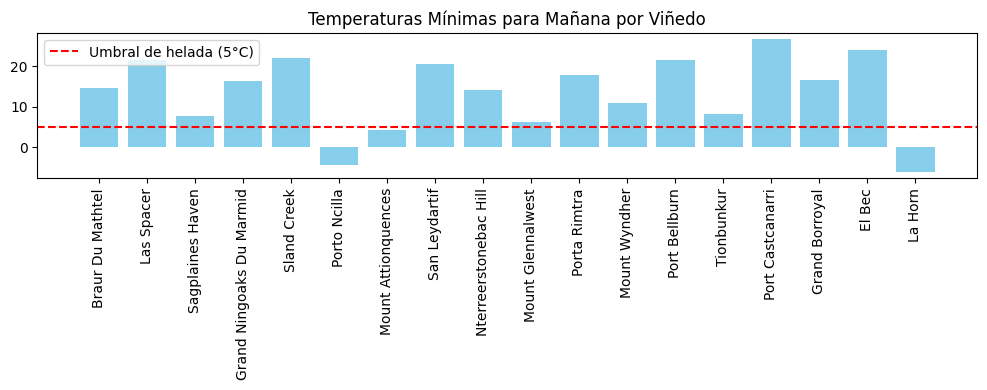

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(final_data["Vineyard Name"], final_data["Today+1 Min Temp"], color="skyblue")
plt.axhline(y=5, color="red", linestyle="--", label="Umbral de helada (5°C)")
plt.title("Temperaturas Mínimas para Mañana por Viñedo")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

## 🏁 Conclusión

Este proyecto automatiza con éxito el monitoreo de heladas en viñedos, usando **fuentes externas, limpiezas complejas y APIs**.
Ha sido validado contra los requerimientos de Kubicle y puede ampliarse con **alertas automáticas por email, dashboards o sistemas IoT** en el futuro.